# XGBoost and SUSY


#### Overview

In this notebook, we will focus on using Gradient Boosted Trees (in particular XGBoost) to classify the supersymmetry (SUSY) dataset, first introduced by [Baldi et al. Nature Communication 2015 and Arxiv:1402.4735](https://arxiv.org/pdf/1402.4735.pdf). The supersymmetry data set consists of 5,000,000 Monte-Carlo samples of supersymmetric and non-supersymmetric events (with 18 features) coming from a dummy high-energy particle collider experiments. The *signal process* is the production of electrically-charged
supersymmetric particles which decay to W bosons and an electrically-neutral supersymmetric
particle that is invisible to the detector.


![alt text](../lesson2/images/susy_sig.png "Title")

The background process is the production of pairs of W bosons, which decay to charged leptons l and invisible neutrinos ν.

![alt text](../lesson2/images/susy_bkg.png "Title")

The first 8 features are "raw" (low-level) kinematic features that can be directly measured from collisions (e.g. lepton $p_T$). The final 10 features are "hand constructed" (high-level) features that have been chosen using physical knowledge, and are known to be important in distinguishing supersymmetric and non-supersymmetric collision events. More specifically, they are (from the paper):

<img src="https://github.com/fsimone91/course_ml4hep/blob/2024/notebooks/lesson2/images/susy_vars.png?raw=1"  width="60%">

As we will see (and have seen), there are many practical trade-offs we have to worry about. Unlike Random Forests, for more complicated algorithms such as XGBoost, overfitting can be a major worry. It is also extremely computationally expensive to do hyperparameter searches.

#### Downloading the SUSY dataset
The supersymmetry dataset can be downloaded from the UCI Machine Learning repository on [https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz](https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz). The dataset is quite large (~2GB). *Download the dataset and unzip it in a directory*.

In [1]:
!curl http://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz -o SUSY.csv.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  879M    0  879M    0     0  51.1M      0 --:--:--  0:00:17 --:--:-- 55.0M


In [7]:
!gzip -d SUSY.csv.gz

### Load in dataset and construct training and test set

In [8]:
#Load the dataset using pandas and numpy

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [9]:
#Filename [CHANGE THIS TO YOUR FILENAME FOR SUSY]
filename='./SUSY.csv'

In [10]:
#Read in SUSY File. We will only work with subset of data for demonstration purposes.

features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi',
 'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2',
 'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi',
 'missing energy magnitude', 'missing energy phi']

high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

In [11]:
#Number of datapoints to work with, limiting to 100k for the moment
N = 100000
print("Size of dataset : %i"%N)
df = pd.read_csv(filename, header=None,nrows=N,engine='python')
df.columns=features
y = df['SUSY'].values
X = df[[col for col in df.columns if col!="SUSY"]]

Size of dataset : 100000


In [12]:
#Make datasets using only the 8 low-level features and 10 high-level features
X_low=X[low_features]
X_high=X[high_features]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, random_state=0)
X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X_low, y, test_size=.1, random_state=0)
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y, test_size=.1, random_state=0)

In [14]:
df.to_pickle("susy_small.pkl",compression="gzip")

In [15]:
df.head()

,SUSY,lepton 1 pT,lepton 1 eta,lepton 1 phi,lepton 2 pT,lepton 2 eta,lepton 2 phi,missing energy magnitude,missing energy phi,MET_rel,axial MET,M_R,M_TR_2,R,MT2,S_R,M_Delta_R,dPhi_r_b,cos(theta_r1)
0,0.0,0.972861,0.653855,1.176225,1.157156,-1.739873,-0.874309,0.567765,-0.175000,0.810061,-0.252552,1.921887,0.889637,0.410772,1.145621,1.932632,0.994464,1.367815,0.040714
1,1.0,1.667973,0.064191,-1.225171,0.506102,-0.338939,1.672543,3.475464,-1.219136,0.012955,3.775174,1.045977,0.568051,0.481928,0.000000,0.448410,0.205356,1.321893,0.377584
2,1.0,0.444840,-0.134298,-0.709972,0.451719,-1.613871,-0.768661,1.219918,0.504026,1.831248,-0.431385,0.526283,0.941514,1.587535,2.024308,0.603498,1.562374,1.135454,0.180910
3,1.0,0.381256,-0.976145,0.693152,0.448959,0.891753,-0.677328,2.033060,1.533041,3.046260,-1.005285,0.569386,1.015211,1.582217,1.551914,0.761215,1.715464,1.492257,0.090719
4,1.0,1.309996,-0.690089,-0.676259,1.589283,-0.693326,0.622907,1.087562,-0.381742,0.589204,1.365479,1.179295,0.968218,0.728563,0.000000,1.083158,0.043429,1.154854,0.094859


### Train and test models

In [16]:
# For next cell
from sklearn.metrics import roc_auc_score
import time
#import xgboost as xgb
import warnings

In [18]:
!sudo pip install xgboost

In [20]:
!sudo pip install --upgrade xgboost
import xgboost as xgb

In [21]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

print("Training on %i examples with %i features"%X_train.shape)

#Use default parameters and train on full dataset
XGBclassifier = xgb.sklearn.XGBClassifier(nthread=-1, seed=1, n_estimators=1000)
#Train and time classifier
start_time = time.time()
XGBclassifier.fit(X_train, y_train)
run_time = time.time() - start_time

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_test.shape)
y_pred= XGBclassifier.predict(X_test)

#Print Results
print("Model Accuracy with all features: {:.2f}%".format(100*XGBclassifier.score(X_test, y_test)))
print("The AUC score with all features is {:.2f}".format(roc_auc_score(y_test,y_pred)))
print("Run time with all features: {:.2f} sec\n\n".format(run_time))


#Rerun with just low-level kinematic features with default parameters

print("Training on %i examples with %i features"%X_low_train.shape)
XGBclassifier_low = xgb.sklearn.XGBClassifier(nthread=-1, seed=1)
#Train and time classifier
start_time = time.time()
XGBclassifier_low.fit(X_low_train, y_low_train)
run_time = time.time() - start_time

#Make Predictions
print("Predicting on %i examples with %i features\n"%X_low_test.shape)
y_low_pred = XGBclassifier_low.predict(X_low_test)

#Print Results
print("Model Accuracy with just low-level kinematic features: {:.2f}%".format(100*XGBclassifier_low.score(X_low_test, y_low_test)))
print("The low-level AUC score is {:.2f}".format(roc_auc_score(y_test,y_low_pred)))
print("Run time with low-level features: {:.2f} sec\n\n".format(run_time))


#Rerun with just high-level kinematic features with default parameters

print("Training on %i examples with %i features\n"%X_high_train.shape)
XGBclassifier_high = xgb.sklearn.XGBClassifier(nthread=-1, seed=1)
#Train and time classifier
start_time = time.time()
XGBclassifier_high.fit(X_high_train, y_high_train)
run_time = time.time() - start_time

print("Training on %i examples with %i features"%X_high_test.shape)
#Make Predictions
y_high_pred = XGBclassifier_high.predict(X_high_test)

#Print Results
print("Model Accuracy with just high-level features: {:.2f}%".format(100*XGBclassifier_low.score(X_low_test, y_low_test)))
print("The high-level AUC score is {:.2f}".format(roc_auc_score(y_test,y_high_pred)))
print("Run time with high-level features: {:.2f} sec\n\n".format(run_time))

Training on 90000 examples with 18 features
Predicting on 10000 examples with 18 features

Model Accuracy with all features: 77.85%
The AUC score with all features is 0.77
Run time with all features: 89.73 sec


Training on 90000 examples with 8 features
Predicting on 10000 examples with 8 features

Model Accuracy with just low-level kinematic features: 78.61%
The low-level AUC score is 0.78
Run time with low-level features: 11.95 sec


Training on 90000 examples with 10 features

Training on 10000 examples with 10 features
Model Accuracy with just high-level features: 78.61%
The high-level AUC score is 0.78
Run time with high-level features: 7.87 sec




## Visualizing Feature Importance

One nice aspect of XGBoost (and ensemble methods in general) is that it is easy to visualize feature importances. In XGBoost, there are some handy plots for viewing these (similar functions also exist for the scikit implementation of random forests). One thing we can calculate is the feature importance score (Fscore), which measures how many times each feature was split on. The higher this number, the more fine-tuned the partitions in this direction, and presumably the more informative it is for our classification task.


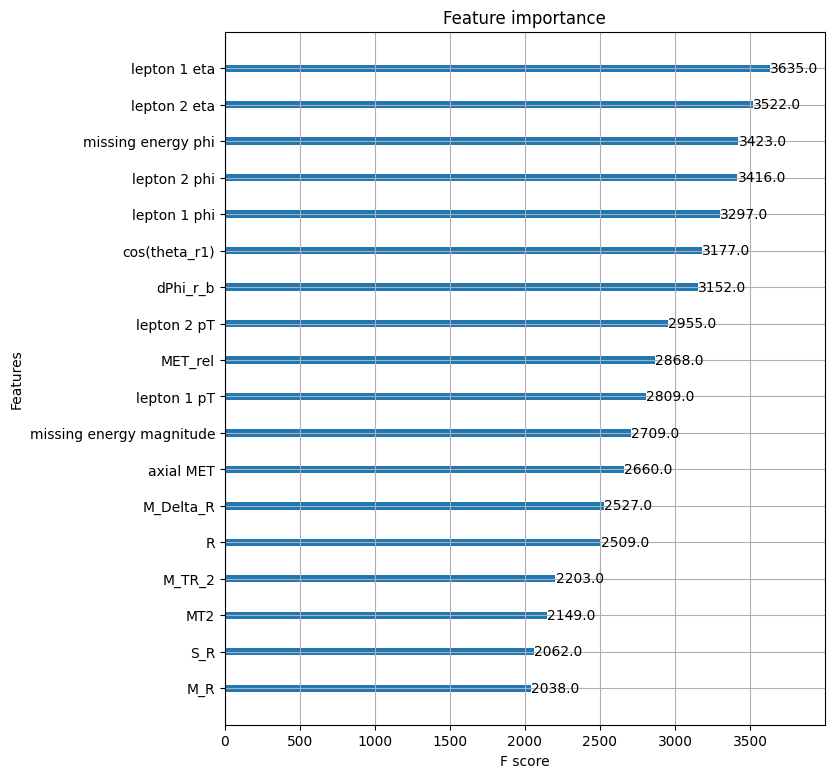

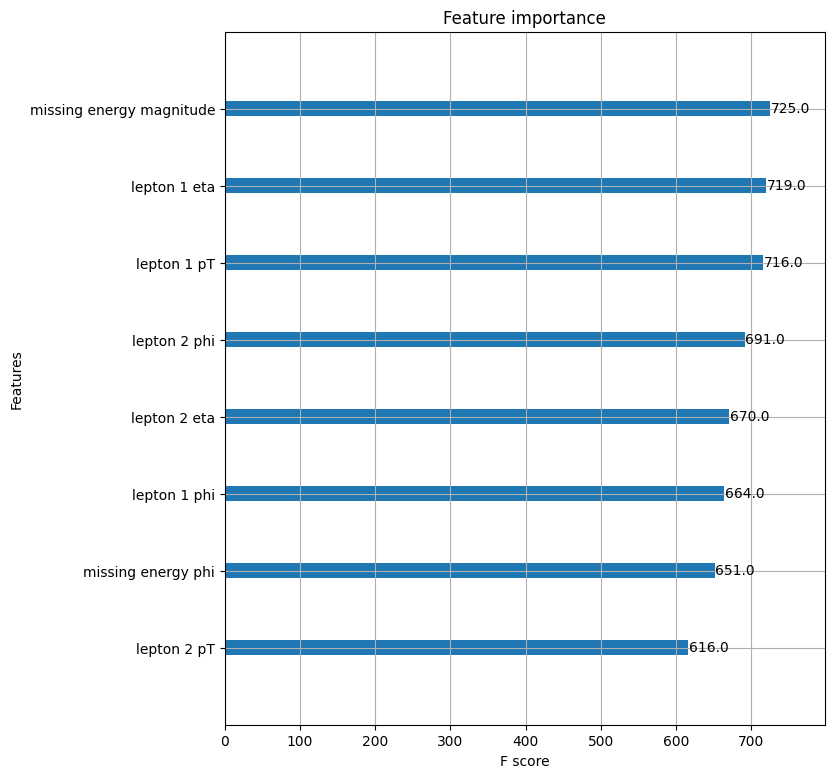

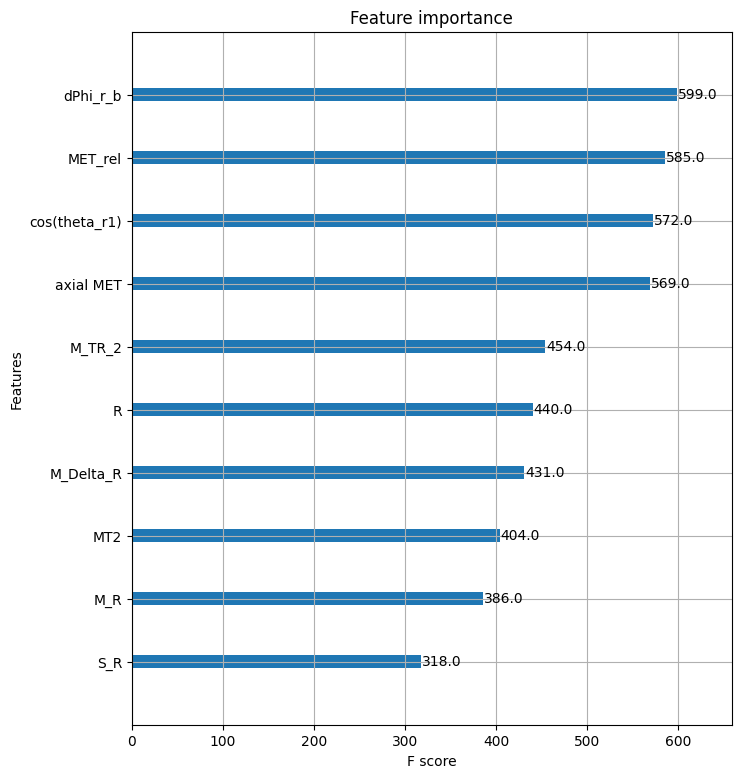

In [23]:
#import ml_style as style
import matplotlib as mpl
#mpl.rcParams.update(style.style)
import matplotlib.pyplot as plt

%matplotlib inline

fig=plt.figure(figsize=(12,9))
xgb.plot_importance(XGBclassifier, ax=plt.gca())
fig.subplots_adjust(left=0.4)  #
#fig.savefig('SUSYXGBoost1.pdf')

fig=plt.figure(figsize=(12,9))
xgb.plot_importance(XGBclassifier_low, ax=plt.gca())
fig.subplots_adjust(left=0.4)
#fig.savefig('SUSYXGBoost2.pdf')
fig=plt.figure(figsize=(12,9))
xgb.plot_importance(XGBclassifier_high, ax=plt.gca())
fig.subplots_adjust(left=0.4)
#fig.savefig('SUSYXGBoost3.pdf')


## Plot ROC curves

This simple example shows that with the default parameters one can already achieve an accuracy of about 80 percent using all the features (kinematic and hand crafted), and a slightly smaller accuracy of about 78.75% using just the kinematic features.  Both achieve a very respectable AUC (area under the ROC curve, see [https://en.wikipedia.org/wiki/Receiver_operating_characteristic](https://en.wikipedia.org/wiki/Receiver_operating_characteristic)) score of around 0.78 or 0.79. This is significantly better than that achieved using Boosted Decision Trees (though not deep neural networks) in the original [paper](https://www.nature.com/articles/ncomms5308), even without tuning hyperparameters. Furthermore, we are using only a small subset of all the data (100,000 out of a total of 5,000,000 datapoints) so this performance is a lower bound on what can be accomplished with XGBoost. Note that there are only three points on the curve so the ROC does not contain much information beyond the accuracy.

We can summarize this by plotting the ROC curves for these three models. Recall that ROC curves plot the true positive rate. Here, we will use the modified version used in high-energy physics plotting the true negative rate (Background rejection) against the true positive rate (signal efficiency).


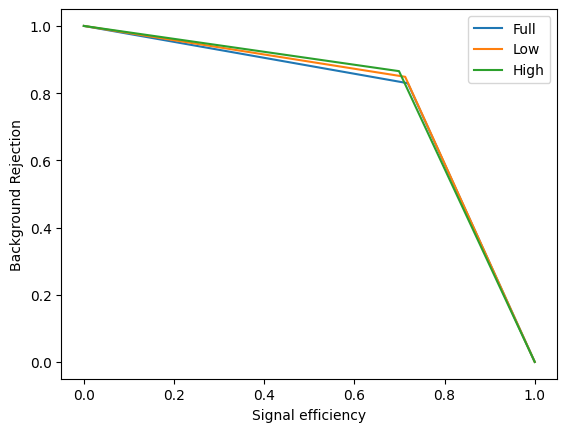

In [24]:
from sklearn.metrics import roc_curve


%matplotlib inline

fpr, tpr, _ = roc_curve(y_test, y_pred)
fpr_low, tpr_low, _ = roc_curve(y_test, y_low_pred)
fpr_high, tpr_high, _ = roc_curve(y_test, y_high_pred)
plt.figure(1)
plt.plot(tpr, 1-fpr, label='Full')
plt.plot(tpr_low, 1-fpr_low, label='Low')
plt.plot(tpr_high, 1-fpr_high, label='High')
plt.legend(loc=1)
plt.xlabel('Signal efficiency')
plt.ylabel('Background Rejection')
#plt.savefig("SUSY_roc_XGBoost.pdf")



## Optimizing XGBoost

We will now optimize the parameters of the XGBoost algorithm by performing a grid search. We will use the very useful new function from scikit-learn `GridSearchCV()`. This function allows you to specify lists of parameters to search over.

Let us briefly discuss what parameters we can tune to improve performance with descriptions:

* `max_depth` [default=6]: maximum depth of a tree, increasing this value will make the model more complex / likely to overfit.

* `eta` or 'learning_rate'[default =0.3]: step size shrinkage used in update to prevent overfitting. After each boosting step, we can directly get the weights of new features. `eta` actually shrinks the feature weights to make the boosting process more conservative.

* `gamma` or min-split-loss [default=0]: This is the penalty that regularizes the number of leaves. The larger, the more conservative the algorithm will be.

* `min_child_weight` [default=1]: In linear regression mode, this simply corresponds to the minimum number of instances needed to be in each node (min $B_j$ in notation of manuscript). The larger, the more conservative the algorithm will be. More generally, it is the minimum sum of instance weight (Hessian) needed in a child. If the tree partition step results in a leaf node with the sum of instance weight less than min_child_weight, then the building process will give up further partitioning.


As you can see this cross-validation procedure is quite computationally expensive. With the parameters below, it takes somewhere between 2 and 5 minutes on a powerful laptop. In the cell below, we perform the search and examine the results in the subsequent results.

In [ ]:
from sklearn.model_selection import GridSearchCV

#Create values to search over
cv_params = {'max_depth': [3,4,6], 'min_child_weight': [1,3,5], 'learning_rate':[0.1,0.3]}
ind_params = {'n_estimators': 100, 'seed':1, 'colsample_bytree': 1,
             'objective': 'binary:logistic'}
opt_XGBclassifier = GridSearchCV(xgb.XGBClassifier(**ind_params),
                            cv_params,
                             scoring = 'accuracy', cv = 5, n_jobs = -1, verbose=3)

opt_XGBclassifier.fit(X_train, y_train)
opt_XGBclassifier.grid_scores_

Fitting 5 folds for each of 18 candidates, totalling 90 fits


In [ ]:
#Print scores
print('The optimal score on training set is {:0.3f}'.format(opt_XGBclassifier.best_score_))

#Find optimal parameters

print('The optimal parameters for the classifier are:')
print(opt_XGBclassifier.best_params_)

#Fit performance on the test set
XGBclassifier_final=opt_XGBclassifier.best_estimator_
y_pred_final=XGBclassifier_final.predict(X_test)
print("Model Accuray with optimal parameters: {:.2f}%".format(100*XGBclassifier_final.score(X_test, y_test)))
print("The  AUC score is {:.2f}".format(roc_auc_score(y_test,y_pred_final)))


## Further Optimization: early stopping and computational efficiency

We see that we have slightly improved our performance. The default parameters work pretty well. Here, we have used relatively small ensembles (100) to make things faster. In practice, it is worth using much bigger ensembles, in which case overfitting and optimization are likely to have larger effects.

Following this very nice blog post, [https://jessesw.com/XG-Boost/](https://jessesw.com/XG-Boost/), we can do some further optimization of the XGBoost algorithm. Part of this is computational and has to do with how we interface with XGBoost, and part will be due to another regularization technique that we discussed in the gradient descent chapter: *early stopping*. Early stopping is now considered one of the most important regularization techniques. The basic idea behind it is to just stop the gradient descent once some measure of error stops going down significantly.

You are invited to play with the code and experiment with this yourself.
